In [1]:
!pip install tensorly
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric

import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

In [2]:
df = pd.read_feather("/home/owner/Documents/DEV/graphs/graphs_and_structural_analysis/data_source/bank_products/train.feather")
df

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391596,2016-05-28,1166765,N,ES,V,22,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
391597,2016-05-28,1166764,N,ES,V,23,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
391598,2016-05-28,1166763,N,ES,H,47,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
391599,2016-05-28,1166789,N,ES,H,22,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [3]:
col_names = {"ncodpers":"cust_id", "ind_empleado":"emp_index", "pais_residencia":"residence",
            "sexo":"sex","fecha_alta":"first_date","ind_nuevo":"new_cust","antiguedad":"seniority",
            "indrel":"is_primary","ult_fec_cli_1t":"last_primary_date","indrel_1mes":"cust_type",
            "tiprel_1mes":"cust_rel_type","indresi":"residence_index","indext":"foreigner_index",
            "conyuemp":"spouse_index","canal_entrada":"channel","cod_prov":"province","nomprov":"province_name",
            "ind_actividad_cliente":"active_index","renta":"income","segmento":"segment"
            }

df.rename(col_names, axis = 1, inplace = True)

In [4]:
df['sex'] = df['sex'].map({'H': 'M', 'V': 'F'})

In [5]:
df.age = pd.to_numeric(df.age, errors='coerce')
df.income = pd.to_numeric(df.income, errors='coerce')
df.seniority = pd.to_numeric(df.seniority, errors='coerce')
df.first_date = pd.to_datetime(df.first_date, errors = 'coerce')
df.cust_type = pd.to_numeric(df.cust_type, errors='coerce')
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])

In [6]:
# For features with missing values percentage < 10%, use the most common factor level to impute
cols = ['emp_index','residence','sex','first_date','new_cust','is_primary',"cust_type","cust_rel_type",
       "province","province_name","active_index","channel","segment"]

for i in cols:
    print(df[i].value_counts())
    df.loc[df[i].isnull(), i] = df[i].value_counts().index[0]
    
# For features with missing value accounts for over 10%, impute their missing values based on the mean at different dimensions
# For Income, impute the missings using the medians of Customer Segment and Province
df['income'].fillna(df['income'].mean(), inplace = True)

N    13610977
B        3566
F        2523
A        2492
S          17
Name: emp_index, dtype: int64
ES    13553710
FR        5161
AR        4835
DE        4625
GB        4605
        ...   
ZW          11
DJ          11
JM          11
BM           6
MT           2
Name: residence, Length: 118, dtype: int64
F    7424252
M    6195253
Name: sex, dtype: int64
2014-07-28    57389
2014-10-03    54287
2014-08-04    45746
2013-10-14    40804
2013-08-03    33414
              ...  
2014-04-27       11
2015-05-31        9
2014-05-01        7
2010-07-04        4
2009-12-25        4
Name: first_date, Length: 6756, dtype: int64
0.0    12808368
1.0      811207
Name: new_cust, dtype: int64
1.0     13594782
99.0       24793
Name: is_primary, dtype: int64
1.0    13490681
3.0        4350
2.0        1317
4.0         306
Name: cust_type, dtype: int64
I    7304875
A    6187123
P       4656
R        870
N          4
Name: cust_rel_type, dtype: int64
28.0    4409600
8.0     1275219
46.0     682304
41.0     6

In [7]:
# filling dummies with NA by 0
dummies = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
          'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
          'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
          'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
          'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
          'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
          'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
          'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
          'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
          'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
          'ind_viv_fin_ult1', 'ind_nomina_ult1',
          'ind_nom_pens_ult1', 'ind_recibo_ult1']

df[dummies] = df[dummies].fillna(0)

In [8]:
# Drop the last primary date and spouse index fields given over 99% missing values
df.drop(['last_primary_date','spouse_index'], axis = 1, inplace = True)

# Инжиниринг фич

In [9]:
# 1) Age group: group the age for lifestages: young, adult, senior, elder
age_group = [0, 20, 45, 65, 100]
age_labels = ['young', 'adult', 'senior', 'elder']

df['age_grouped'] = pd.cut(df.age, bins = age_group, labels = age_labels)

In [10]:
# 2) Income Group: group the incomes at Low, Ordinary, Median-high and High classes at (real case may be more complex)
import numpy as np
df_income_group = [0, np.nanpercentile(df['income'], 25), np.nanpercentile(df['income'], 50), np.nanpercentile(df['income'], 75), np.nanpercentile(df['income'], 100)]
income_labels = ['Low','Ordinary','Median-high','High']

df['income_grouped'] = pd.cut(df['income'], df_income_group, labels = income_labels)

In [11]:
# categorical = df.columns[(df.dtypes == "object") | (df.dtypes == "category")]
# for column in categorical:
#     df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
#     df.drop(columns=column, inplace=True)

In [12]:
print("[", end="")
for column in df.columns: print(f"{column}, ", end="")
print("]")

[fecha_dato, cust_id, emp_index, residence, sex, age, first_date, new_cust, seniority, is_primary, cust_type, cust_rel_type, residence_index, foreigner_index, channel, indfall, tipodom, province, province_name, active_index, income, segment, ind_ahor_fin_ult1, ind_aval_fin_ult1, ind_cco_fin_ult1, ind_cder_fin_ult1, ind_cno_fin_ult1, ind_ctju_fin_ult1, ind_ctma_fin_ult1, ind_ctop_fin_ult1, ind_ctpp_fin_ult1, ind_deco_fin_ult1, ind_deme_fin_ult1, ind_dela_fin_ult1, ind_ecue_fin_ult1, ind_fond_fin_ult1, ind_hip_fin_ult1, ind_plan_fin_ult1, ind_pres_fin_ult1, ind_reca_fin_ult1, ind_tjcr_fin_ult1, ind_valo_fin_ult1, ind_viv_fin_ult1, ind_nomina_ult1, ind_nom_pens_ult1, ind_recibo_ult1, age_grouped, income_grouped, ]


In [13]:
for dummy1 in dummies:
    for dummy2 in dummies:
        if dummy1 == dummy2: continue
        df[dummy2] = (~df[dummy1].astype(bool)) & df[dummy2].astype(bool)

In [14]:
df['service_name'] = pd.from_dummies(df[dummies], default_category="Unknown")

In [15]:
df['service_name'].value_counts()

ind_cco_fin_ult1     11503962
ind_cno_fin_ult1       851859
ind_ctop_fin_ult1      443799
Unknown                224806
ind_ecue_fin_ult1      174677
ind_ctju_fin_ult1      113881
ind_ctma_fin_ult1       84543
ind_dela_fin_ult1       64576
ind_reca_fin_ult1       61256
ind_recibo_ult1         27854
ind_ctpp_fin_ult1       21460
ind_tjcr_fin_ult1       20752
ind_deco_fin_ult1       13368
ind_plan_fin_ult1        9937
ind_valo_fin_ult1        6495
ind_fond_fin_ult1        5368
ind_hip_fin_ult1         4628
ind_nomina_ult1          4384
ind_pres_fin_ult1        3209
ind_viv_fin_ult1         2979
ind_ahor_fin_ult1         957
ind_deme_fin_ult1         945
ind_nom_pens_ult1         805
ind_cder_fin_ult1         703
ind_aval_fin_ult1         106
Name: service_name, dtype: int64

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['service_id'] = le.fit_transform(df['service_name'])

# Постобработка

In [17]:
products_by_age_groups = df.groupby('age_grouped')['service_name'].value_counts()
products_by_age_groups = products_by_age_groups.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)

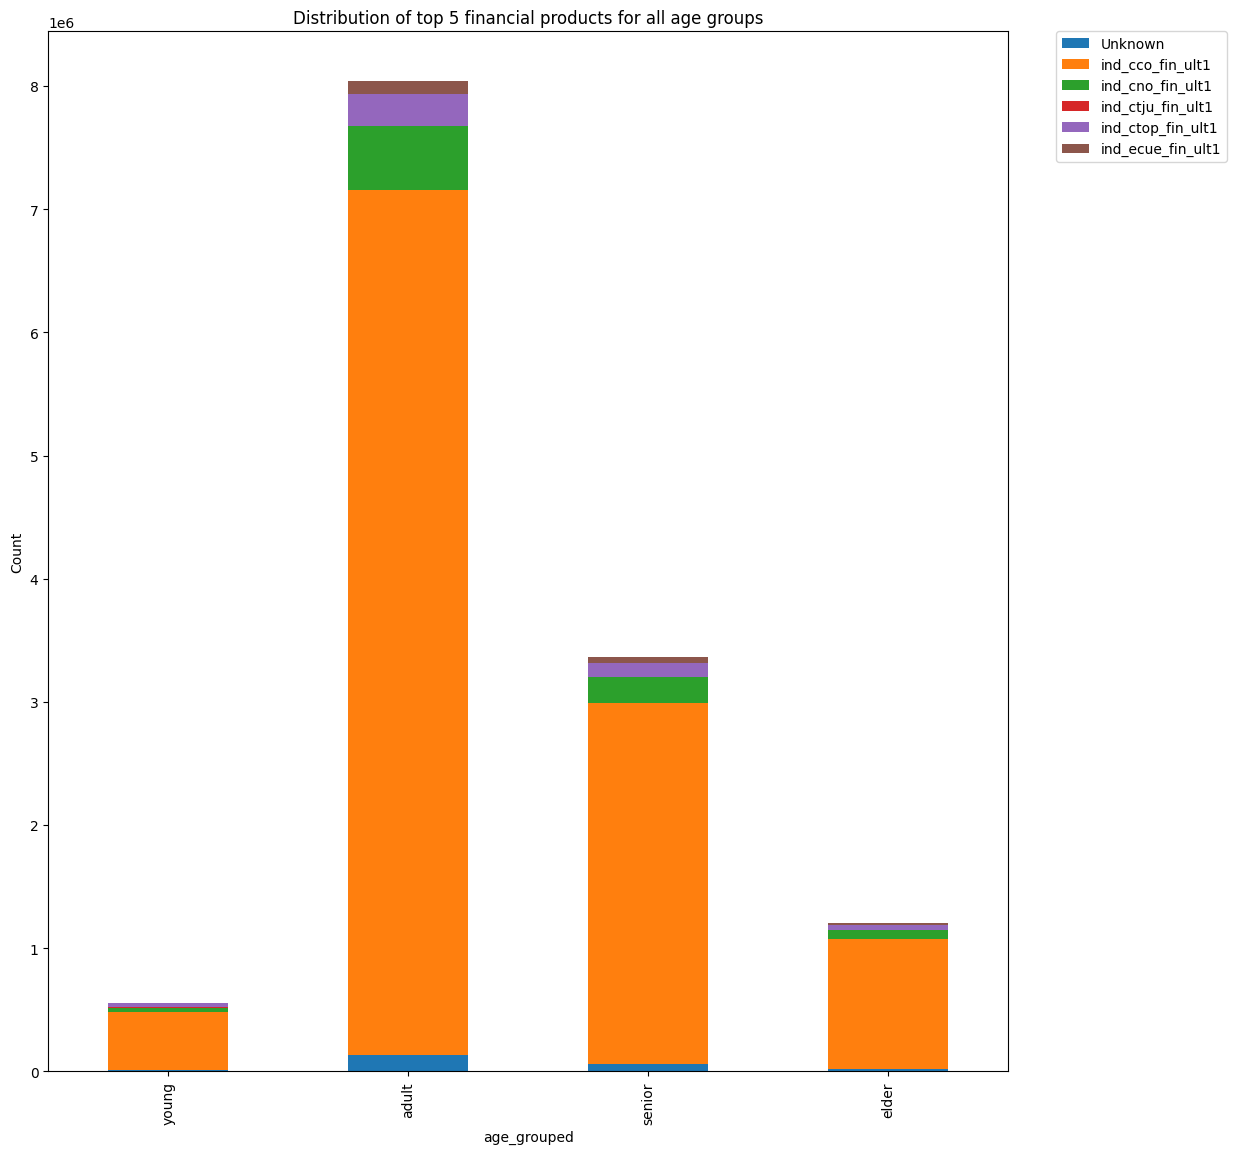

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
products_by_age_groups.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of top 5 financial products for all age groups')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [19]:
products_by_sex = df.groupby('sex')['service_name'].value_counts()
products_by_sex = products_by_sex.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)

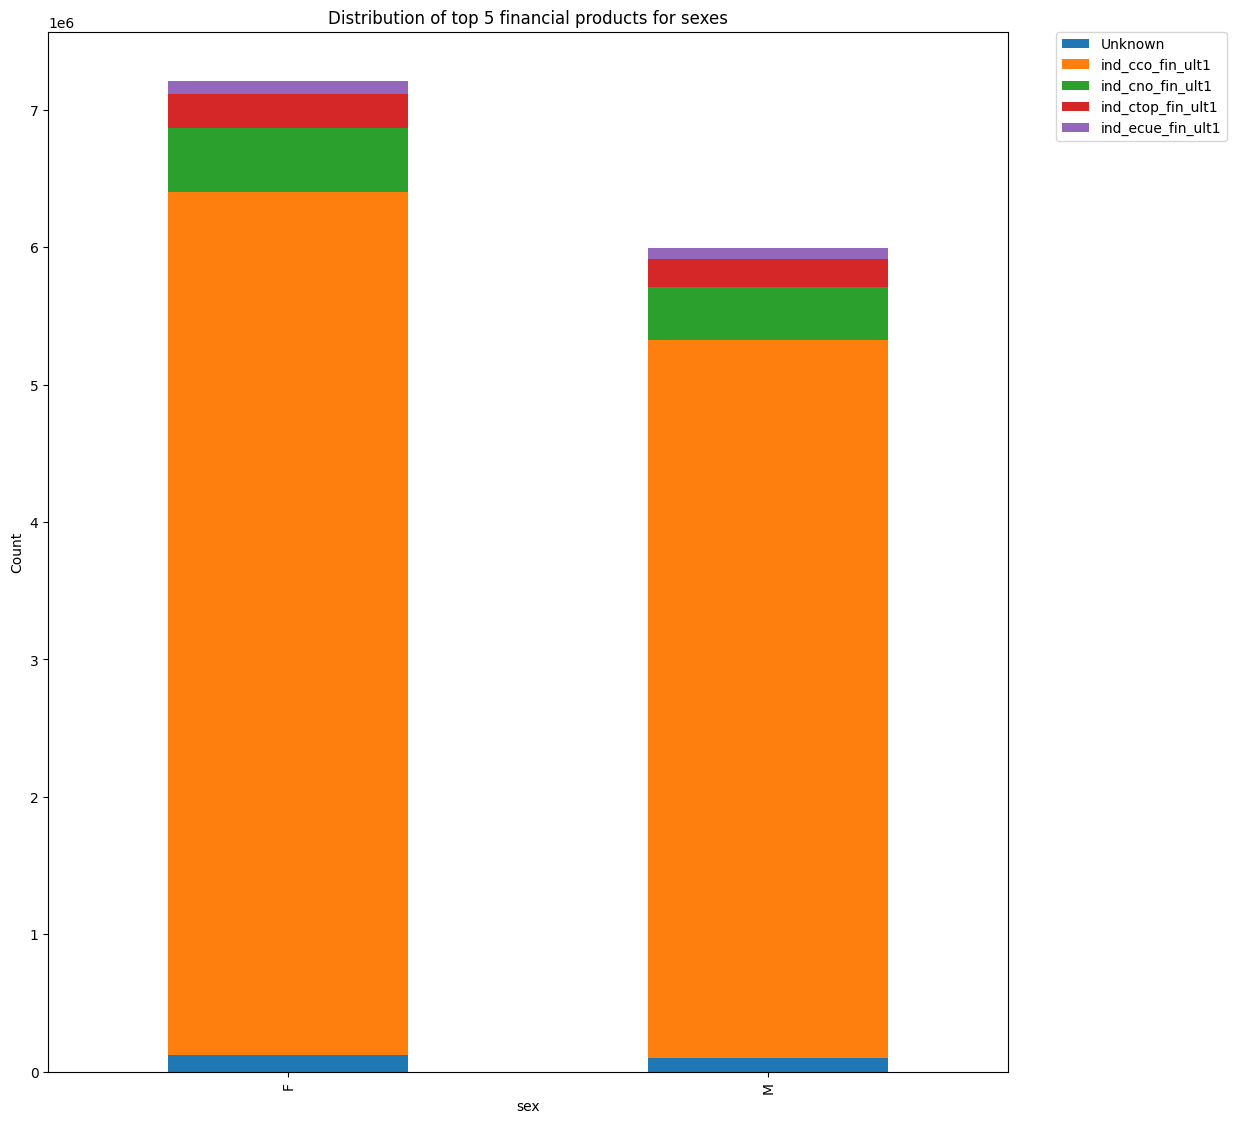

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
products_by_sex.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of top 5 financial products for sexes')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [21]:
df.columns

Index(['fecha_dato', 'cust_id', 'emp_index', 'residence', 'sex', 'age',
       'first_date', 'new_cust', 'seniority', 'is_primary', 'cust_type',
       'cust_rel_type', 'residence_index', 'foreigner_index', 'channel',
       'indfall', 'tipodom', 'province', 'province_name', 'active_index',
       'income', 'segment', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1', 'age_grouped', 'income_grouped', 'service_name',
       'service_id'],
      dtype='object')

In [22]:
data = df[['cust_id', 'service_name', 'service_id']].rename({'cust_id': 'customer_id'}, axis = 1)

In [23]:
data = data.sample(len(data) // 100)
data

,customer_id,service_name,service_id
375898,976445,ind_ctop_fin_ult1,8
214544,382856,ind_cco_fin_ult1,3
80940,438629,ind_cco_fin_ult1,3
196884,408411,ind_cco_fin_ult1,3
202022,571771,ind_cco_fin_ult1,3
...,...,...,...
102981,1097032,ind_cco_fin_ult1,3
175877,776332,ind_cco_fin_ult1,3
238448,1103048,ind_cco_fin_ult1,3
163032,812122,ind_cco_fin_ult1,3


In [24]:
import networkx as nx
G = nx.Graph()

In [25]:
user_nodes = data['customer_id'].unique()
item_nodes = data['service_id'].unique()
G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(item_nodes, bipartite=1)
for user, item in zip(data['customer_id'], data['service_id']):
    G.add_edge(user, item, weight=1)

nx.write_gexf(G, 'graph.gexf')

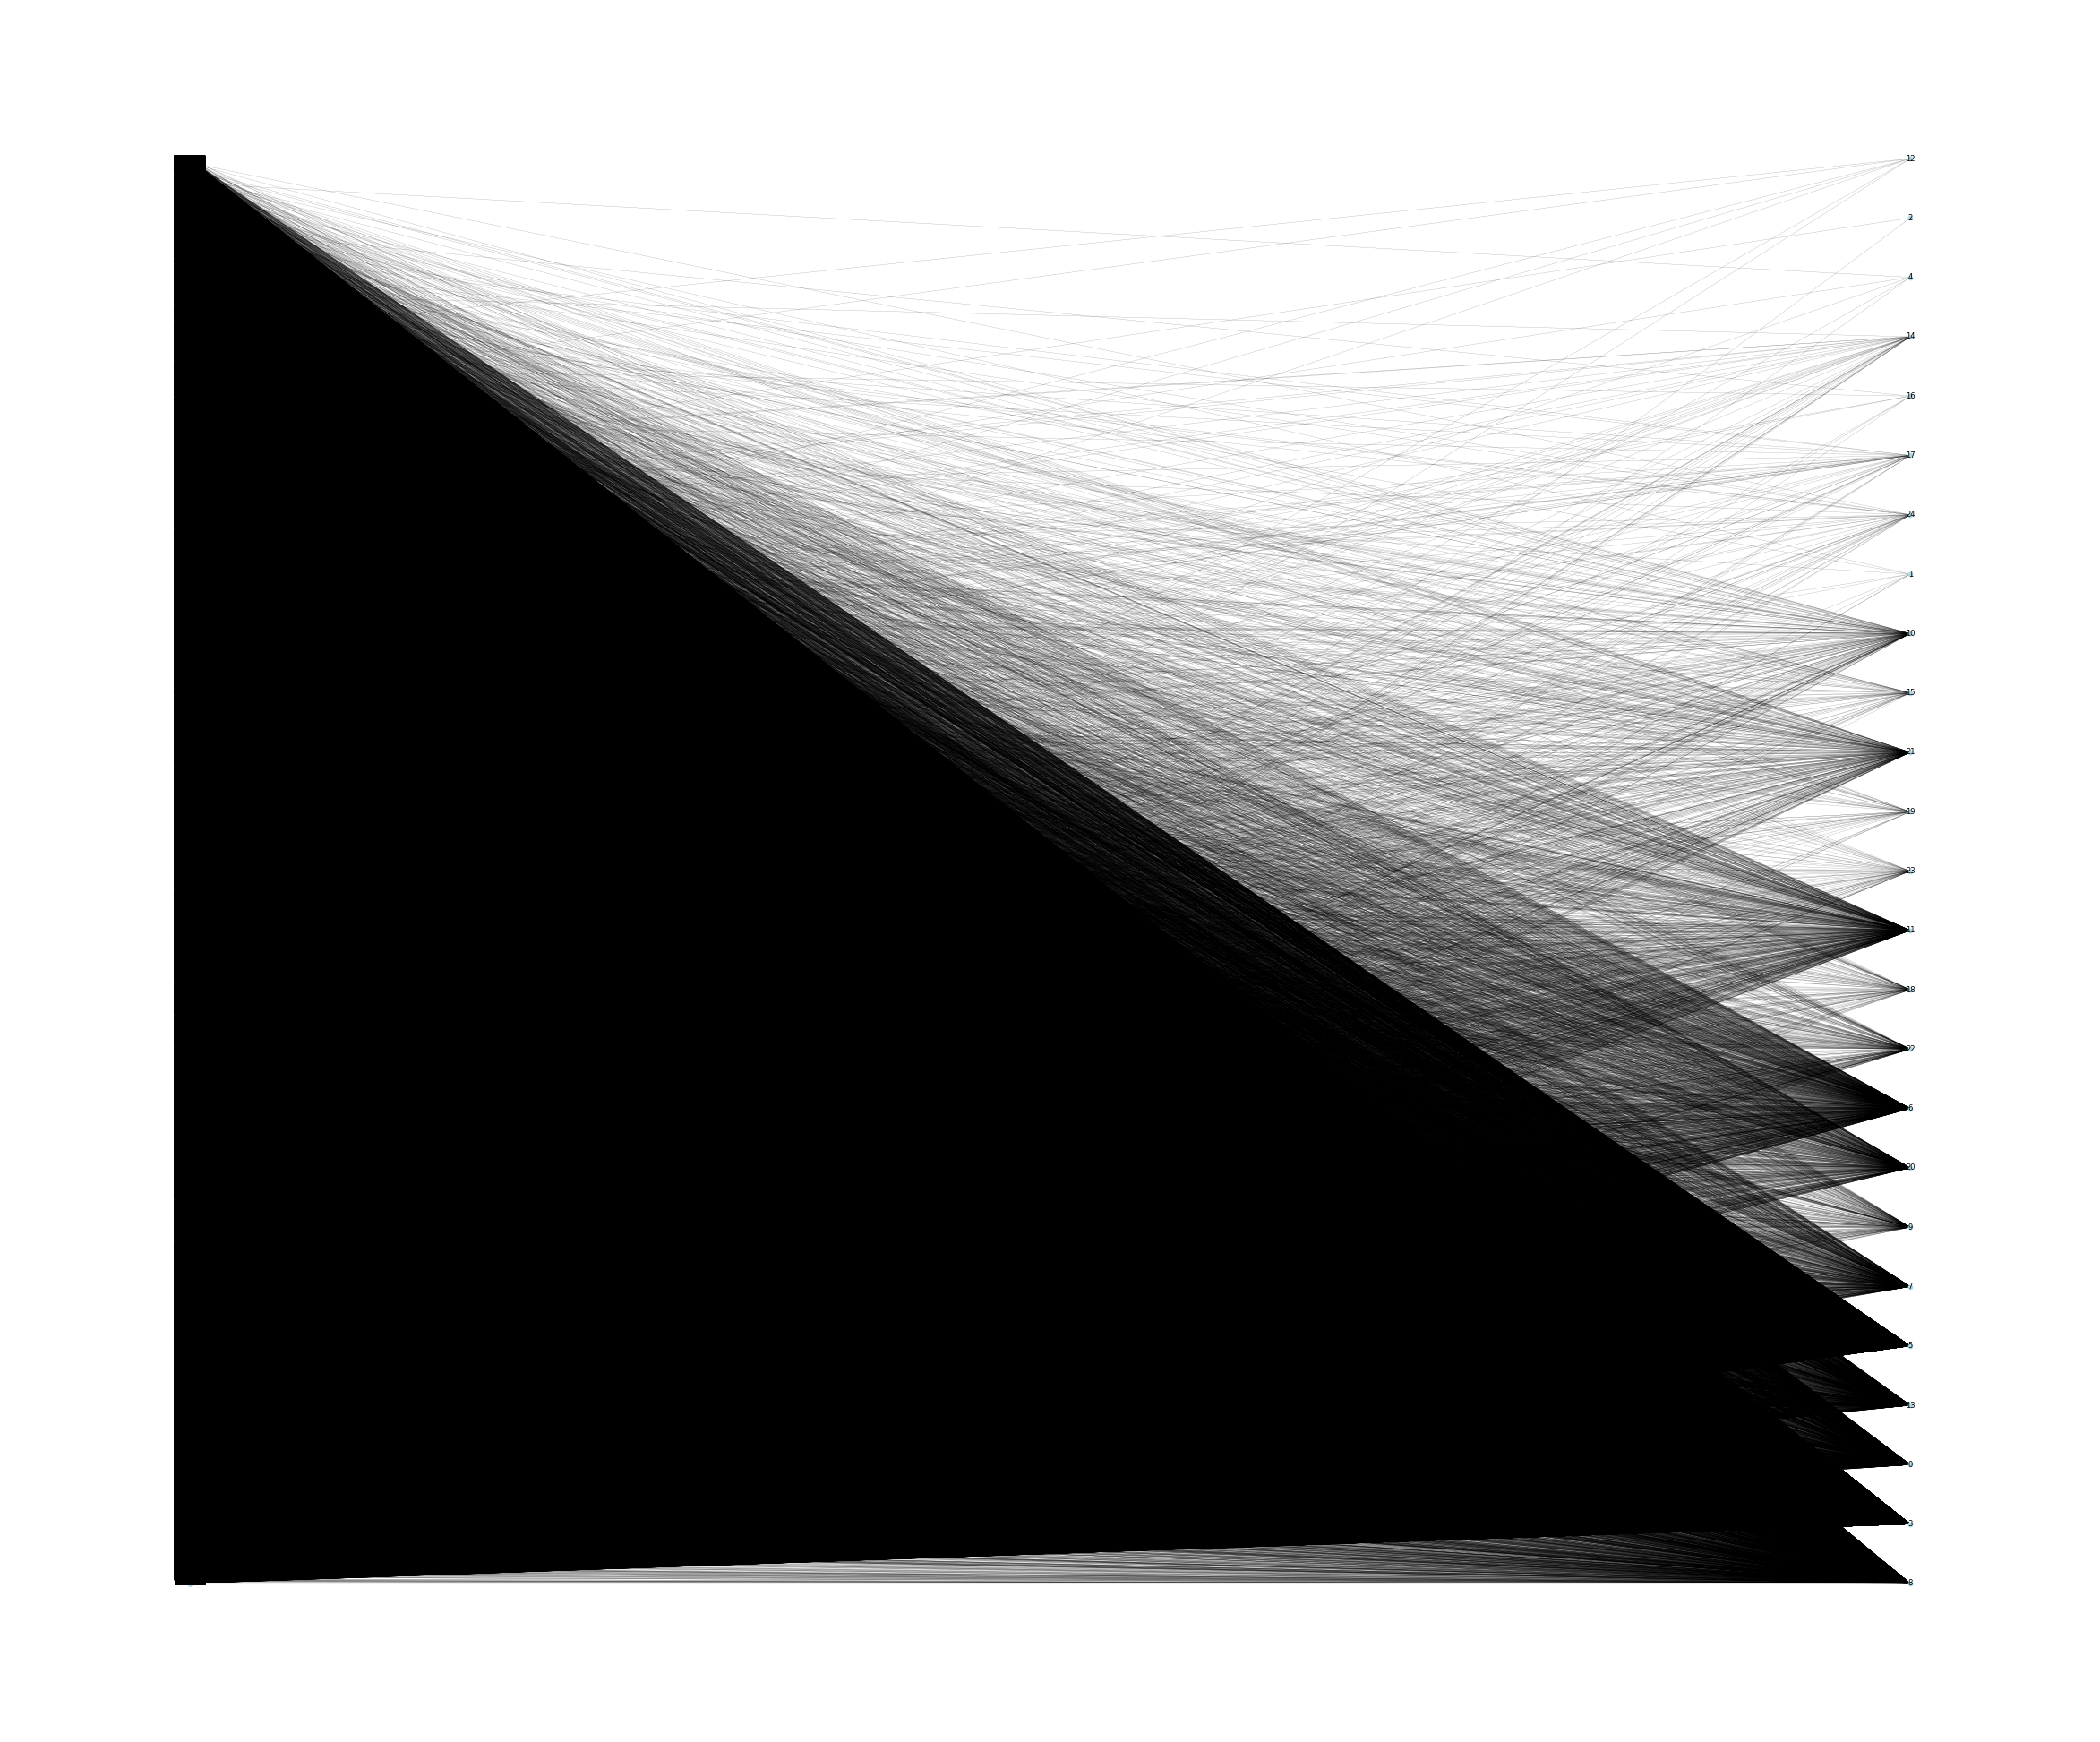

In [26]:
plt.figure(figsize=(30, 25))
pos = nx.bipartite_layout(G, nodes = user_nodes, )
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')
plt.axis('off')
plt.show()

In [27]:
print(df.service_id.unique())

[ 3 10  0  5 13 21  6 22 20 11 19  7 17 23 14 12 18 16 15  8  4  9  2 24
  1]


## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

In [7]:
from recommender import LightGCN_recommender

ModuleNotFoundError: No module named 'torch_scatter'